# Naive Bayes Classifier

## Dataset Configuration
Code taken and adjusted from the lab. We import the train and test data from the keras imdb dataset, converting it to the necessary format for the model.

In [11]:
m = 2500   # Number of words in the vocabulary
n = 200    # N most frequent words to skip
k = 0      # K least frequent words to skip

infogain = False # Not used by default
g = 800 

In [12]:
import tensorflow as tf
import numpy as np
from math import log 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Binary Vector Creation
Converts the dataset data into a binary vector, where each word is represented by a 1 or 0. 1 if the word is present in the review, 0 if it is not.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = np.array(x_train_binary.toarray())
x_test_binary = np.array(x_test_binary.toarray())

X is a matrix of vectors (reviews) where each vector is a binary vector representing the words in the review. 
Y is a vector of labels (0 or 1) where 0 is a negative review and 1 is a positive one.

$$X = \begin{bmatrix} \vec{x_{1}} \\ \vdots \\ \vec{x_{m}} \end{bmatrix}\, \, \, 
y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{m} \end{bmatrix}$$

### Information Gain
Performs information gain on the dataset, returning the top g words with the highest information gain. Uses the code from the lab.

In [14]:
from math import log 

if infogain:
  def IG(class_, feature):
    classes = set(class_)

    Hc = 0
    for c in classes:
      pc = list(class_).count(c)/len(class_)
      Hc += - pc * log(pc, 2)
    feature_values = set(feature)

    Hc_feature = 0
    for feat in feature_values:
      
      #pf --> P(X=x)
      pf = list(feature).count(feat)/len(feature)
      indices = [i for i in range(len(feature)) if feature[i] == feat]
      clasess_of_feat = [class_[i] for i in indices]
      for c in classes:
          #pcf --> P(C=c|X=x)
          pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
          if pcf != 0: 
              # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
              temp_H = - pf * pcf * log(pcf, 2)
              #sum for all values of C (class) and X (values of specific feature)
              Hc_feature += temp_H
    ig = Hc - Hc_feature
    return ig    

  # Selecting the g most important features
  ig = [(i, IG(y_train, x_train_binary[:, i])) for i in range(len(x_train_binary[0]))]
  ig.sort(key=lambda x: x[1], reverse=True)
  ig = ig[:g]

  x_train_binary = x_train_binary[:, [i[0] for i in ig]]
  x_test_binary = x_test_binary[:, [i[0] for i in ig]]

## Visualizations
A few visualizations of the results. Utilizes thoroughly adjusted and optimized code from the lab and multiple libraries.

In [15]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import learning_curve
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
from seaborn import heatmap
from pandas import DataFrame
import IPython.display as ipd


def classification_data(estimator, 
                          x_train, y_train,
                          x_test, y_test,
                          splits = 5):
  """
  Trains a model on a training set and evaluates it on both the 
  training and test sets for a given number of splits. Calculates
  the accuracy, precision, recall and F1 score for each split as
  well as the final confusion matrix.  
  
  Arguments:
    estimator obj: The model to be trained and evaluated
    x_train, x_test: The binary training and test data. 
    y_train, y_test: The training and test labels (0 or 1). 
    n_splits: The number of splits to use for training.
  Returns: 
    A dictionary containing the train/test accuracies, precisions,
    recalls and F1 scores as well as the final confusion matrix.
  """

  train_accuracies, test_accuracies, train_precisions, test_precisions, train_recall, test_recall, train_f1, test_f1 = [], [], [], [], [], [], [], []
  
  # Split the training data into n splits
  split_size = int(len(x_train) / splits)
  x_splits = np.split(x_train, splits)
  y_splits = np.split(y_train, splits)
  test_cm = None
  
  # Train the model on each split and evaluate on the test set
  for i in range(0, len(x_splits)):
    if i == 0:
      curr_x = x_splits[0]
      curr_y = y_splits[0]
    else:
      curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
      curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    
    # Train the model and get train/test predictions
    estimator.fit(curr_x, curr_y)
    train_pred = estimator.predict(curr_x)
    test_pred = estimator.predict(x_test)
    
    # Calculate and save the necessary metrics for this train/test split
    train_accuracies.append(accuracy_score(curr_y, train_pred))
    test_accuracies.append(accuracy_score(y_test, test_pred))
    
    train_precisions.append(precision_score(curr_y, train_pred))
    test_precisions.append(precision_score(y_test, test_pred))
    
    train_recall.append(recall_score(curr_y, train_pred))
    test_recall.append(recall_score(y_test, test_pred))
    
    train_f1.append(f1_score(curr_y, train_pred))
    test_f1.append(f1_score(y_test, test_pred))
  
  # Calculate the final confusion matrix
  cm = confusion_matrix(y_test, test_pred)
  
  
  # Results required for all the future plots/tables
  return {'estimator': estimator.__class__.__name__, 
          'split_size': split_size, 
          'splits': splits,
          'test_predictions': test_pred,
          'train_accuracy': train_accuracies, 
          'test_accuracy': test_accuracies, 
          'train_precision': train_precisions, 
          'test_precision': test_precisions, 
          'train_recall': train_recall, 
          'test_recall': test_recall, 
          'train_f1': train_f1, 
          'test_f1': test_f1,
          'final_cm': cm}
  
  
def classification_cm_heatmap(cm, title):
    """
    Creates a heatmap of the confusion matrix.  
    
    Arguments:
      cm: The confusion matrix to be plotted.
      title: The title of the plot.
    Returns: 
      A heatmap of the confusion matrix.
    """
    
    
    cm_matrix = DataFrame(data=cm, columns=['Predict Negative: 0', 'Predicted Positive: 1'],
                          index=['Actual Negative: 0', 'Actual Positive: 1'])
    ax = plt.axes()
    ax.set_title('Confusion Matrix Heatmap for {title}'.format(title=title))
    return heatmap(cm_matrix, annot=True, fmt='d')
  
  
def classification_table(classification_data):
  """
  Creates a table of the train/test accuracies, precisions, recalls
  and F1 scores for each split.
  
  Arguments:
    classification_data: The dictionary containing the train/test data
  Returns: 
    A dataframe table of the train/test accuracies, precisions, recalls and F1 scores
  """
    
  split_size = classification_data['split_size']
  df = DataFrame(data={'Train Accuracy': np.round(classification_data['train_accuracy'], 2), 
                         'Test Accuracy': np.round(classification_data['test_accuracy'], 2), 
                         'Precision Train' : np.round(classification_data['train_precision'], 2), 
                         'Precision Test' : np.round(classification_data['test_precision'], 2), 
                         'Recall Train' : np.round(classification_data['train_recall'], 2), 
                         'Recall Test' : np.round(classification_data['test_recall'], 2), 
                         'F1 Train' : np.round(classification_data['train_f1'], 2), 
                         'F1 Test' : np.round(classification_data['test_f1'], 2)}, 
                   index=list(range(split_size, len(x_train) + split_size, split_size)))
  return df


def classification_plots(classification_data, full_scale=False):
  """
  Plots the learning curves for the train/test accuracies, precisions, recalls
  and F1 scores for each split in one figure.
  
  Arguments:
    classification_data: The dictionary containing the train/test data
    full_scale: Whether or not to plot the full scale of the y-axis.
  Returns: 
    A figure containing the learning curves for the train/test accuracies, precisions, recalls and F1 scores.
  """
  
  split_size = classification_data['split_size']
  splits = classification_data['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve for {estimator}".format(estimator=classification_data['estimator']), fontsize=16)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#2c8dc9", label="Training")
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#FFAD00", label="Testing")
      axis[i, j].grid(alpha = 0.3)  
  
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
 
  return figure


def classification_plots_compare(classification_data_x, classification_data_y, full_scale=False):
  """
  Plots the learning curves for the train/test accuracies, precisions, recalls
  and F1 scores for each split in one figure for both classifiers.
  
  Arguments:
    classification_data_x: The dictionary containing the train/test data for the first classifier.
    classification_data_y: The dictionary containing the train/test data for the second classifier.
    full_scale: Whether or not to plot the full scale of the y-axis.
  Returns: 
    A figure containing the learning curves for the train/test accuracies, precisions, recalls and F1 scores 
    for both classifiers.
  """
  
  split_size = classification_data_x['split_size']
  splits = classification_data_x['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve Comparison for {estimator} against {estimator_2} ".format(estimator=classification_data_x['estimator'], estimator_2=classification_data_y['estimator']), fontsize=12)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#AD49C2", label="Training {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#7CC249", label="Testing {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#2c8dc9", label="Training {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#FFAD00", label="Testing {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].grid(alpha = 0.3) 
    
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
  return figure

## Bernoulli Naive Bayes Classifier Implementation
A class that implements the Bernoulli Naive Bayes Classifier. The class has two methods: train and predict. 
The train method takes a list of binary vectors and a list of labels and trains the classifier. 
The predict method takes a list of binary vectors and returns a list of labels.

Laplacian smoothing is used to avoid zero probabilities.

In [16]:
class BernoulliNaiveBayes:
  
  def __init__(self):
    pass 

  def fit(self, X, y):
    # Calculate the a-priori (log) probability for each class
    self.p_log_pos = np.log(np.sum(y) / len(y))
    self.p_log_neg = np.log(1 - np.sum(y) / len(y))
    
    # Calculate the (log) probability of each set of features given each class (y = 1 (Good) or y = 0 (Bad))
    # p(feature|class) = (np.sum(X[y == class], axis=0) + 1) / (np.sum(y) + 2)
    self.p_log_pos_feature1 = np.log((np.sum(X[y == 1], axis=0) + 1) / (np.sum(y) + 2))
    self.p_log_neg_feature1 = np.log((np.sum(X[y == 0], axis=0) + 1) / (len(y) - np.sum(y) + 2))
    self.p_log_pos_feature0 = np.log(1.0 - (np.sum(X[y == 1], axis=0) + 1) / (np.sum(y) + 2))
    self.p_log_neg_feature0 = np.log(1.0 - (np.sum(X[y == 0], axis=0) + 1) / (len(y) - np.sum(y) + 2))
    
    
  def predict(self, X):
    X_reverse = np.where((X==0)|(X==1), X^1, X)
    p_log_pos = X_reverse.dot(self.p_log_pos_feature0) + X.dot(self.p_log_pos_feature1) + self.p_log_pos
    p_log_neg = X_reverse.dot(self.p_log_neg_feature0) + X.dot(self.p_log_neg_feature1) + self.p_log_neg
    
    return np.array([1 if p_log_pos[i] > p_log_neg[i] else 0 for i in range(len(X))])

## Bernoulli Naive Bayes Classifier Results and Comparison
The Bernoulli Naive Bayes Classifier is tested on the test data and the results are visualized. The results are compared to the results of other relevant classifiers from the SKLearn library.


              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.87,0.83,0.88,0.85,0.86,0.81,0.87,0.83
10000,0.86,0.84,0.87,0.85,0.86,0.83,0.87,0.84
15000,0.86,0.84,0.86,0.85,0.85,0.82,0.86,0.84
20000,0.85,0.84,0.86,0.85,0.84,0.82,0.85,0.83
25000,0.85,0.84,0.85,0.85,0.85,0.83,0.85,0.84


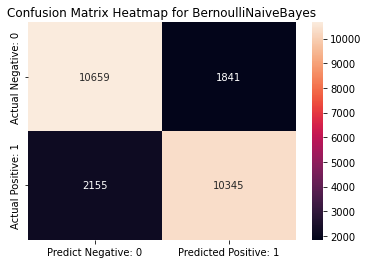

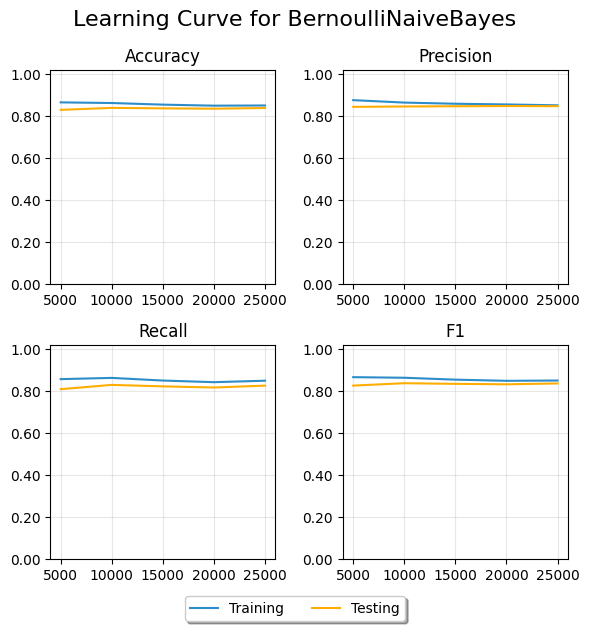

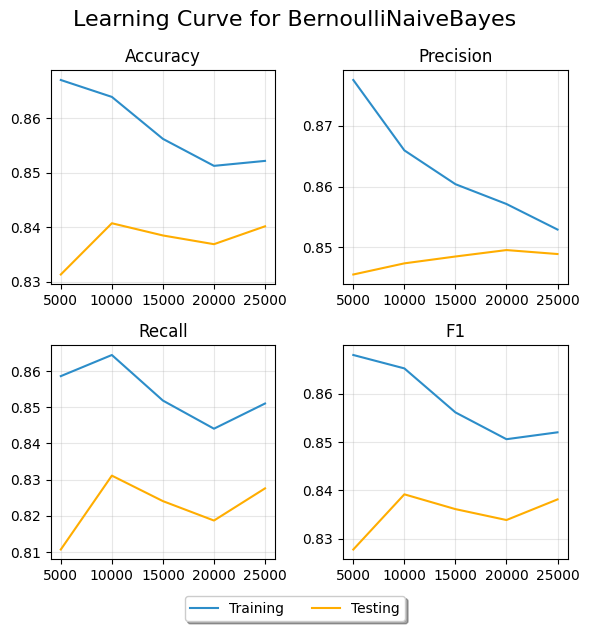

In [17]:
bnb_data = classification_data(BernoulliNaiveBayes(), x_train_binary, y_train, x_test_binary, y_test, 5)

print(classification_report(y_test, bnb_data['test_predictions']))
bnb_cf_hmp = classification_cm_heatmap(bnb_data['final_cm'], bnb_data['estimator'])
bnb_cf_tbl = classification_table(bnb_data)
ipd.display(bnb_cf_tbl)

bnb_cf_tplt = classification_plots(bnb_data, True)
bnb_cf_fplt = classification_plots(bnb_data)

### Bernoulli Naive Bayes against SKLearn's Bernoulli Naive Bayes
The Bernoulli Naive Bayes Classifier is tested against the SKLearn Bernoulli Naive Bayes Classifier. The results are visualized and analyzed.
We expect the results to be similar, as the SKLearn implementation is a well known and optimized implementation.

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


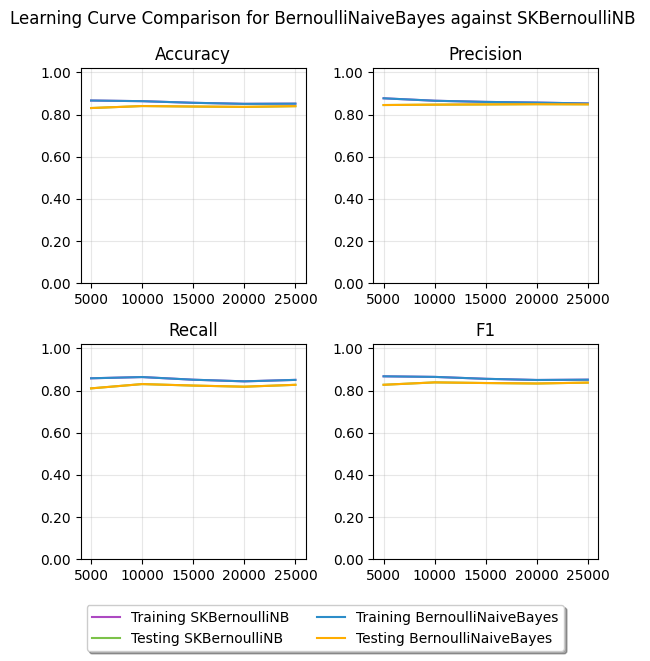

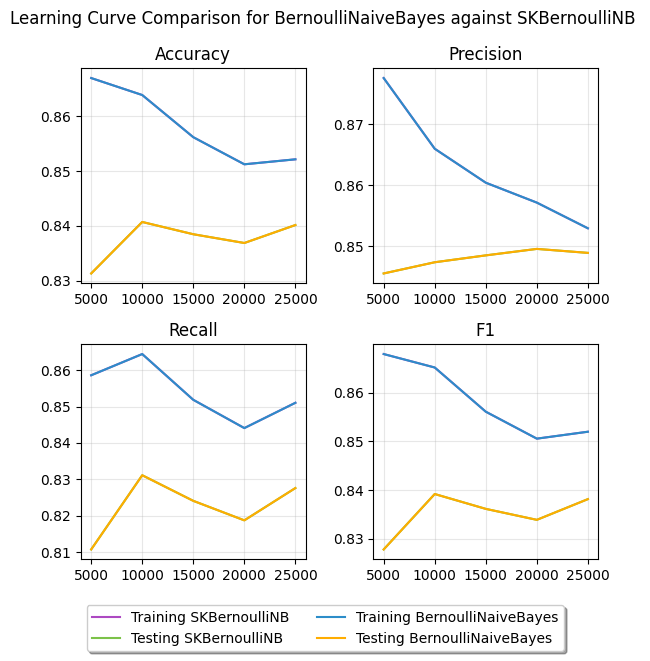

In [18]:
from sklearn.naive_bayes import BernoulliNB

skbnb_data = classification_data(BernoulliNB(), x_train_binary, y_train, x_test_binary, y_test, 5)
skbnb_data['estimator'] = 'SKBernoulliNB'
# skbnb_cf_hmp = classification_cm_heatmap(skbnb_data['final_cm'], skbnb_data['estimator'])
skbnb_cf_tbl = classification_table(skbnb_data)
bnb_skbnb_tbl = bnb_cf_tbl - skbnb_cf_tbl
bnb_skbnb_tbl = bnb_skbnb_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=bnb_data['estimator'], estimator_2=skbnb_data['estimator']))
ipd.display(bnb_skbnb_tbl)

bnb_skbnb_tplt = classification_plots_compare(bnb_data, skbnb_data, True)
bnb_skbnb_fplt = classification_plots_compare(bnb_data, skbnb_data)

### Comparison of Bernoulli Naive Bayes with SKLearn's DecisionTreeClassifier

The Bernoulli Naive Bayes Classifier is tested against the SKLearn ID3 Decision Tree Classifier. The results are visualized and analyzed.

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.120000,0.140000,0.190000,0.210000,-0.070000,-0.070000,0.080000,0.090000
10000,0.120000,0.140000,0.190000,0.200000,-0.070000,-0.070000,0.090000,0.090000
15000,0.130000,0.140000,0.190000,0.200000,-0.080000,-0.080000,0.080000,0.090000
20000,0.120000,0.130000,0.190000,0.200000,-0.080000,-0.080000,0.080000,0.080000
25000,0.130000,0.130000,0.190000,0.200000,-0.060000,-0.070000,0.080000,0.090000


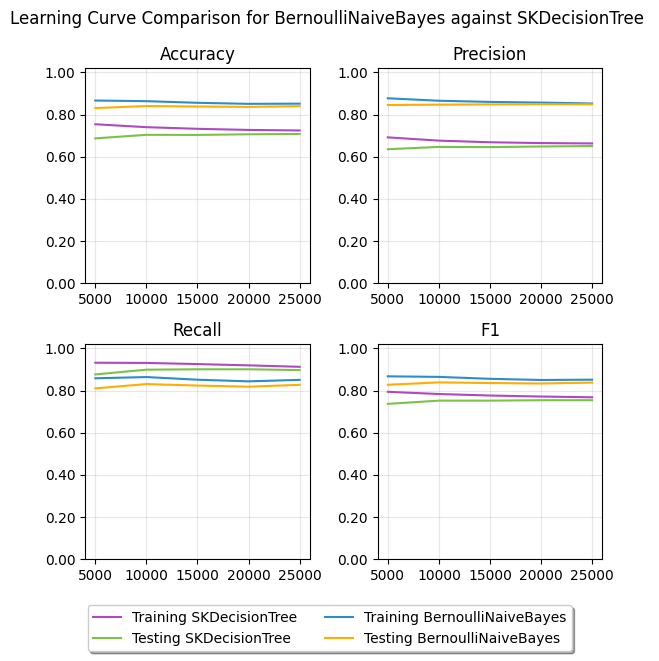

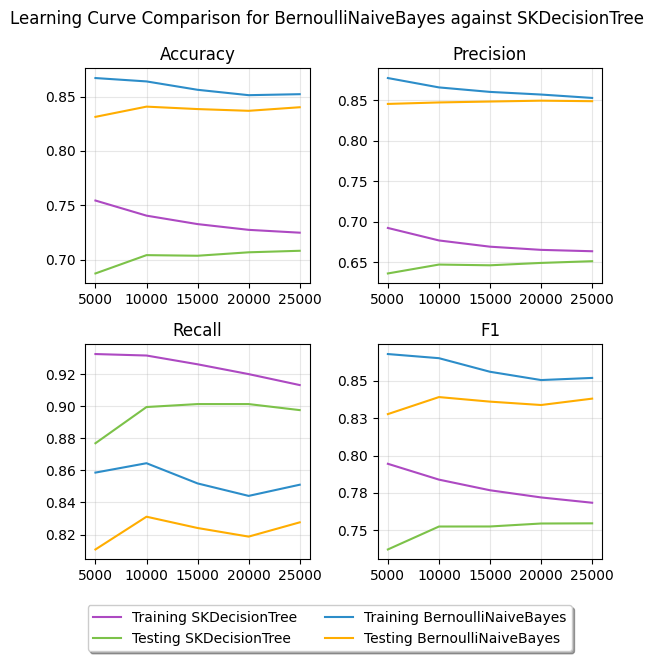

In [19]:
from sklearn import tree

skdt_data = classification_data(tree.DecisionTreeClassifier(criterion='entropy', max_depth=10), x_train_binary, y_train, x_test_binary, y_test, 5)
skdt_data['estimator'] = 'SKDecisionTree'
# skdt_cf_hmp = classification_cm_heatmap(skdt_data['final_cm'], skdt_data['estimator'])
skdt_cf_tbl = classification_table(skdt_data)
bnb_skdt_tbl = bnb_cf_tbl - skdt_cf_tbl
bnb_skdt_tbl = bnb_skdt_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=bnb_data['estimator'], estimator_2=skdt_data['estimator']))
ipd.display(bnb_skdt_tbl)
#skdt_cf_plt = classification_plots(skdt_data, True)
bnb_skdt_tplt = classification_plots_compare(bnb_data, skdt_data, True)
bnb_skdt_fplt = classification_plots_compare(bnb_data, skdt_data)

### Comparison of Bernoulli Naive Bayes with SKLearn's SGDC Classifier

The Bernoulli Naive Bayes Classifier is tested against the SKLearn SGDC Classifier. The results are visualized and analyzed.

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,-0.130000,0.020000,-0.120000,0.040000,-0.140000,0.010000,-0.130000,0.030000
10000,-0.090000,0.010000,-0.070000,0.030000,-0.100000,-0.020000,-0.080000,0.010000
15000,-0.060000,0.000000,-0.070000,0.000000,-0.060000,-0.010000,-0.060000,0.000000
20000,-0.060000,-0.010000,-0.060000,-0.010000,-0.060000,-0.020000,-0.060000,-0.020000
25000,-0.050000,-0.010000,-0.040000,0.010000,-0.070000,-0.040000,-0.050000,-0.010000


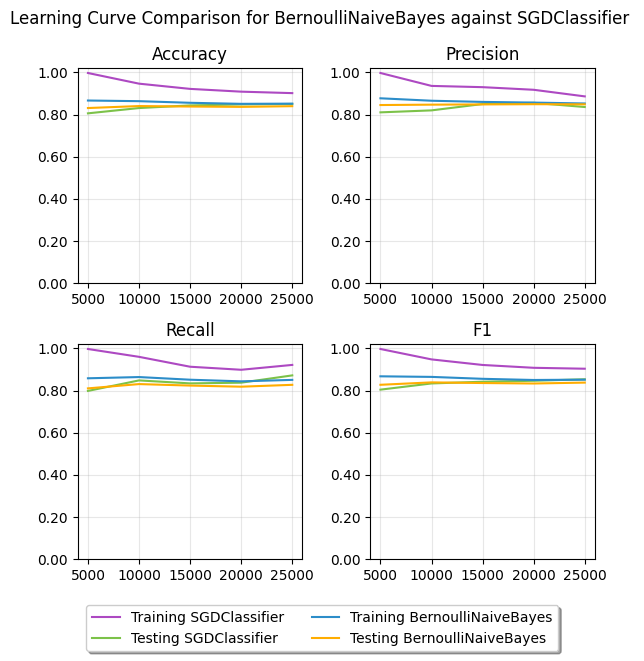

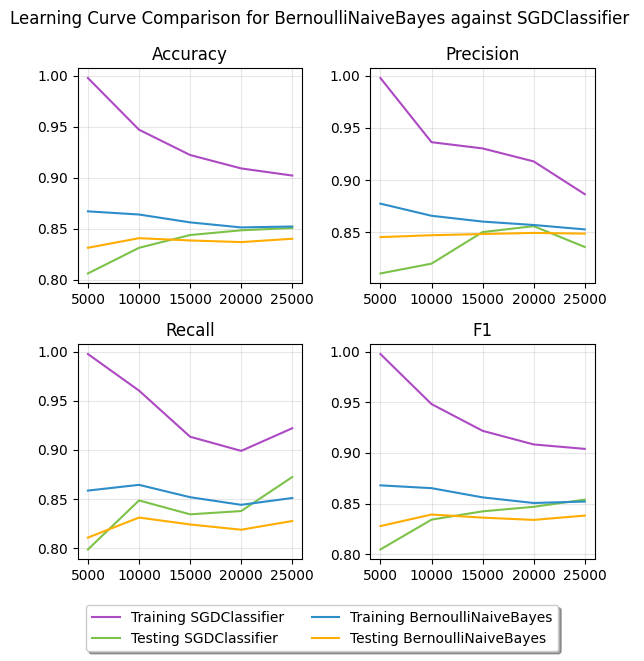

In [20]:
from sklearn.linear_model import SGDClassifier

sklogreg_data = classification_data(SGDClassifier(loss="log_loss"), x_train_binary, y_train, x_test_binary, y_test, 5)
# sklogreg_cf_hmp = classification_cm_heatmap(sklogreg_data['final_cm'], sklogreg_data['estimator'])
sklogreg_cf_tbl = classification_table(sklogreg_data)
bnb_sklogreg_tbl = bnb_cf_tbl - sklogreg_cf_tbl
bnb_sklogreg_tbl = bnb_sklogreg_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=bnb_data['estimator'], estimator_2=sklogreg_data['estimator']))
ipd.display(bnb_sklogreg_tbl)
#sklogreg_cf_plt = classification_plots(sklogreg_data, True)
bnb_sklogreg_tplt = classification_plots_compare(bnb_data, sklogreg_data, True)
bnb_sklogreg_fplt = classification_plots_compare(bnb_data, sklogreg_data)